# Coursework1: Convolutional Neural Networks 
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Paperspace, where you can access GPUs. 

#### Paperspace
See [the Paperspace information doc](https://hackmd.io/@afspies/S1stL8Qnt). 

The public tests are embedded within the notebook and you can ignore the **tests** folder

#### Google Colab
To run this notebook on Google Colab, please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

**To run the public tests within colab** you will need to copy the "tests" folder to the ```/content/``` directory (this is the default working directory - you can also change directories with ```%cd```)

#### Setup
You will need to install pytorch and other libraries by running the following cell:

In [20]:
!pip install -q otter-grader pandoc torch torchvision sklearn seaborn

In [21]:
# Initialization Cell
import otter
grader = otter.Notebook("dl_cw_1.ipynb")
import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
import numpy as np
rng_seed = 90

## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations. 
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic pytorch operations to define the 2D convolution, 2D max pooling, linear layer as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not what to see any _for loops_!

**Your Task**
- implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass
        if isinstance(kernel_size, tuple):
            kernel_x, kernel_y = kernel_size
        elif isinstance(kernel_size, int):
            kernel_x = kernel_y = kernel_size
        
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        # Weights sampled from uniform dist. U(-sqrt(k), sqrt(k)), where
        # k = 1/(in_channels*kernel_x*kernel_y)
        k = 1/(in_channels*kernel_x*kernel_y)
        self.w = torch.rand(out_channels, in_channels, kernel_x, kernel_y)*2*math.sqrt(k) - math.sqrt(k)
        # Bias should have shape [out_channels]
        self.bias = bias
        self.b = None
        if self.bias: 
            # biases initialized similarly to weights
            self.b = torch.rand(out_channels)*2*math.sqrt(k) - math.sqrt(k)
        self.F = out_channels
        self.C = in_channels
        self.kernel_size = (kernel_x, kernel_y)

        if isinstance(stride, tuple):
            self.stride = stride
        elif isinstance(stride, int):
            self.stride = (stride, stride)

        if isinstance(padding, tuple):
            self.padding = padding
        elif isinstance(padding, int):
            self.padding = (padding, padding)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass                                     #
        
        N, C, H, W = x.size()
        H_out = int((H + 2*self.padding[0] - (self.kernel_size[0] - 1) - 1)/self.stride[0] + 1)
        W_out = int((W + 2*self.padding[1] - (self.kernel_size[1] - 1) - 1)/self.stride[1] + 1)
        output_size = (N, self.F, H_out, W_out)

        # Convolution is equivalent with Unfold + Matrix Multiplication + Fold

        # extract sliding local blocks from batched input tensor
        # x_unf has shape [N, C*kernel_x*kernel_y, L], where L = # patches
        # C*kernel_x*kernel_y = # elements per patch
        x_unf = F.unfold(input=x, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)
        # number of patches
        L = x_unf.size(-1)

        # apply convolution
        # out_unf.shape = (N, F, L)
        if self.bias:
            b = np.broadcast_to(self.b, shape=(N, L, self.F))
            b = torch.tensor(b)
            # b.shape = (N, L, F)
            out_unf = (x_unf.transpose(1, 2).matmul(self.w.view(self.w.size(0), -1).t()) + b).transpose(1, 2)
        else:
            out_unf = x_unf.transpose(1, 2).matmul(self.w.view(self.w.size(0), -1).t()).transpose(1, 2)

        # recombine array of sliding local blocks (after convolution) into a large containing tensor
        out = out_unf.view(output_size)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [23]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if isinstance(kernel_size, tuple):
           self.kernel_size = kernel_size
        elif isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        
        self.stride = self.kernel_size
        # default 0 padding
        self.padding = (0, 0)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        N, C, H, W = x.size()
        H_out = int((H + 2*self.padding[0] - (self.kernel_size[0] - 1) - 1)/self.stride[0] + 1)
        W_out = int((W + 2*self.padding[1] - (self.kernel_size[1] - 1) - 1)/self.stride[1] + 1)
        output_size = (N, C, H_out, W_out)

        out = torch.empty(size=output_size)
        # apply max pooling to each channel separately 
        for c in range(C):
            x_c = x[:, c, :, :]
            x_c = x_c.view(x_c.size(0), 1, x_c.size(1), x_c.size(2))
            x_c_unf = F.unfold(input=x_c, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)

            # apply max pooling
            out_c_unf = torch.amax(x_c_unf, dim=1)

            # convert to correct shape
            out_c = out_c_unf.view((N, H_out, W_out))
            out[:, c, :, :] = out_c

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [25]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!

In [26]:
# check Conv2d layer is functioning correctly
input = torch.rand(size=(32, 3, 28, 28))

# our implementation
conv2d = Conv2d(3, 6, kernel_size=3)
w = conv2d.w
b = conv2d.b
maxpool2d = MaxPool2d(kernel_size=2)
# out = conv2d(input)
out = maxpool2d(conv2d(input))

# pytorch implementation
torch_conv2d = nn.Conv2d(3, 6, kernel_size=3)
torch_conv2d.weight = nn.Parameter(w)
torch_conv2d.bias = nn.Parameter(b)
# torch_out = torch_conv2d(input)
torch_maxpool2d = nn.MaxPool2d(kernel_size=2)
torch_out = torch_maxpool2d(torch_conv2d(input))

if torch.all(abs(out - torch_out) < 1e-6):
    print("Implementation correct!")
else:
    print("Error!")

Implementation correct!


In [27]:
import torch
import torch.nn as nn
import numpy as np
import math

class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason

        # Weight matrix has shape [out_channels, in_channels]
        # Weights sampled from uniform dist. U(-sqrt(k), sqrt(k)), where
        # k = 1/in_channels
        k = 1/in_channels
        self.w = torch.rand(out_channels, in_channels)*2*math.sqrt(k) - math.sqrt(k)
        # Bias should have shape [out_channels]
        self.bias = bias
        self.b = None
        if self.bias: 
            # biases initialized similarly to weights
            self.b = torch.rand(out_channels)*2*math.sqrt(k) - math.sqrt(k)
        
        self.in_channels = in_channels
        self.out_channels = out_channels

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        if self.bias:
            if len(x.size()) > 2:
                b_shape = []
                b_shape.extend(list(x.size()[1:-1]))
                b_shape.append(self.out_channels)
                b = np.broadcast_to(self.b, shape=b_shape)
                b = torch.tensor(b)
                out = torch.matmul(x, self.w.t()) + b
            else:
                out = torch.matmul(x, self.w.t()) + self.b
        else:
            out = torch.matmul(x, self.w.t())
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [28]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!

In [29]:
# check Linear layer is functioning correctly
input = torch.rand(size=(32, 28, 28, 3))

# our implementation
linear = Linear(3, 8)
w = linear.w
b = linear.b
out = linear(input)

# pytorch implementation
torch_linear = nn.Linear(3, 8)
torch_linear.weight = nn.Parameter(w)
torch_linear.bias = nn.Parameter(b)
torch_out = torch_linear(input)

if torch.all(abs(out - torch_out) < 1e-6):
    print("Implementation correct!")
else:
    print("Error!")

Implementation correct!


In [30]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum - the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # num_features == C
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # By default, the elements of γ are set to 1 and the elements of β are set to 0
        self.gamma = torch.ones(size=(1,num_features,1,1))  # shape (1, C, 1, 1)
        self.beta = torch.zeros(size=(1,num_features,1,1))  # shape (1, C, 1, 1)

        self.running_mean = torch.zeros(size=(1,num_features,1,1))  # shape (1, C, 1, 1)
        self.running_var = torch.ones(size=(1,num_features,1,1))  # shape (1, C, 1, 1)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # Training mode
        if torch.is_grad_enabled():
            # calculate mean and variance on the channel dimension (axis=1)
            # shapes of mu, var --> (1, C, 1, 1)
            var, mu = torch.var_mean(x, dim=(0,2,3), unbiased=False, keepdim=True)
            x_hat = (x - mu) / torch.sqrt(var + self.eps)

            # update running mean and variance
            self.running_mean = self.momentum*mu + (1 - self.momentum)*self.running_mean
            self.running_var = self.momentum*var + (1 - self.momentum)*self.running_var
        else:
            # Test mode
            x_hat = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)
        
        out = self.gamma*x_hat + self.beta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [31]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!

In [32]:
# check BatchNorm2d layer is functioning correctly
input = torch.rand(size=(32, 3, 28, 28))

# our implementation
batchnorm2d = BatchNorm2d(3)
out = batchnorm2d(input)

# pytorch implementation
torch_batchnorm2d = nn.BatchNorm2d(3)
torch_out = torch_batchnorm2d(input)

if torch.all(abs(out - torch_out) < 1e-6):
    print("Implementation correct!")
else:
    print("Error!")

Implementation correct!


## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (30 points)
    * 10 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (10 points)

**Downloading NaturalImageNet**

In [ ]:
ON_COLAB = True

!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
else: 
    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null

In [ ]:
#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [ ]:
# When we import the images we want to first convert them to a tensor. 
# It is also common in deep learning to normalise the the inputs. This 
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images 
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

class AddGaussianNoise:
    def __init__(self, mean=0, std=0.1):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean


mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

base_transforms = [
                   transforms.Resize(256),
                   transforms.CenterCrop(256),
                   transforms.ToTensor(),
                   transforms.Normalize(mean.tolist(), std.tolist()),
                   ]
base_transforms = transforms.Compose(base_transforms)

# Image augmentation
phflip = 0.5
pnoise = 0.5
augment_transforms = [
    transforms.RandomHorizontalFlip(p=phflip),
    transforms.RandomResizedCrop(size=256, scale=(0.6, 1)),
    transforms.ColorJitter(0.4, 0, 0.4, 0.4),
    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise()], p=pnoise),
    transforms.Normalize(mean.tolist(), std.tolist()),
]
augment_transforms = transforms.Compose(augment_transforms)

train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
test_path = ('/content/' if ON_COLAB else '') +'NaturalImageNetTest'

train_dataset = datasets.ImageFolder(train_path, transform=augment_transforms)
# don't apply all transforms to validation set, so load in separately
val_dataset = datasets.ImageFolder(train_path, transform=base_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=base_transforms)

# Create train val split
n_train = len(train_dataset)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(0.1 * n_train))
train_idx, val_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


batch_size = 128

# DataLoaders
loader_train = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                          shuffle=False, num_workers=2)
loader_val = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler,
                        shuffle=False, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


In [ ]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images** 

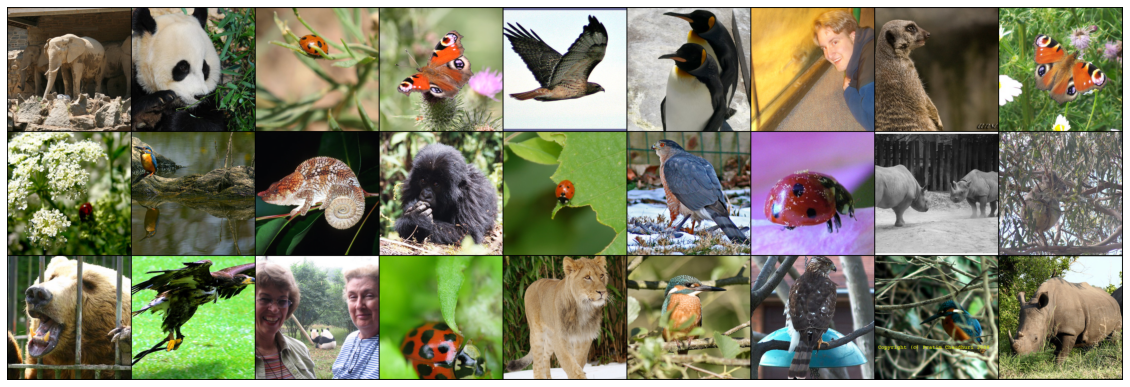

In [ ]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [ ]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(nn.Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  nn.Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(nn.Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 20):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 16
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(16), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer5 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer6 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F


class ResNet18(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 20):
        
        super(ResNet18, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 7, stride = 2,
                                            padding = 3, bias = False), 
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(inplace=True))
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ResNet18C(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 20):
        
        super(ResNet18C, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size = 3, stride = 2,
                                            padding = 1, bias = False), 
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(32, 32, kernel_size=3, stride=1,
                                            padding=1, bias=False),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True), 
                                nn.Conv2d(32, 64, kernel_size=3, stride=1,
                                            padding=1, bias=False),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True))
                                 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class ResidualBlockTweaked(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlockTweaked, self).__init__() 
        
        self.left = nn.Sequential(nn.Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  nn.Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 

        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(nn.AvgPool2d(kernel_size=2, stride=2),
                                          nn.Conv2d(inchannel, outchannel, 
                                                    kernel_size=1, stride=1, 
                                                    padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel)) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out
    

In [ ]:
class SELayer(nn.Module):

    def __init__(self, c, r):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class SEResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1, r=16): 
        
        super().__init__()
        
        self.left = nn.Sequential(nn.Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  nn.Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel),
                                  SELayer(outchannel, r),
                                  ) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(nn.Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


class SEResidualBlockTweaked(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1, r=16): 
        
        super().__init__()
        
        self.left = nn.Sequential(nn.Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  nn.Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel),
                                  SELayer(outchannel, r),
                                  ) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(nn.AvgPool2d(kernel_size=2, stride=2),
                                          nn.Conv2d(inchannel, outchannel, 
                                                    kernel_size=1, stride=1, 
                                                    padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel)) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out

In [ ]:
class ResNet18D(ResNet18):

    def __init__(self):
        super().__init__(ResidualBlock=ResidualBlockTweaked)


class ResNet18E(ResNet18C):

    def __init__(self):
        super().__init__(ResidualBlock=ResidualBlockTweaked)

class ResNet18E_SE(ResNet18C):

    def __init__(self):
        super().__init__(ResidualBlock=SEResidualBlockTweaked)

In [ ]:
# please do not change the name of this class
def MyResNet():
    return ResNet18E_SE()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None, 
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [ ]:
USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)
    

print_every = 10
def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)

        

def train_part(model, optimizer, epochs=1, scheduler=None):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))

        if scheduler is not None:
            scheduler.step()
        
        check_accuracy(loader_val, model)
                

cuda:0


In [ ]:
# define and train the network
model = MyResNet()
optimizer = optim.Adamax(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(loader_train), eta_min=0, last_epoch=-1)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimizer, epochs=50, scheduler=scheduler)


# report test set accuracy
check_accuracy(loader_val, model, analysis=True)


# save the model
torch.save(model.state_dict(), 'model.pt')

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

In [ ]:
USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)
    
    
def check_accuracy_top5(loader, model, topk=(1,5)):

    num_correct_top1 = 0
    num_correct_top5 = 0
    num_samples = 0
    topk = (1, 5)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):

            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)

            maxk = max(topk)
            num_samples += y.size(0)

            output  = model(x)
            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(y.view(1, -1).expand_as(pred))

            num_correct_top1 += correct[:1].reshape(-1).float().sum(0, keepdim=True)
            num_correct_top5 += correct[:5].reshape(-1).float().sum(0, keepdim=True)
        

    top1_acc = float(num_correct_top1) / num_samples
    top5_acc = float(num_correct_top5) / num_samples
    print(f'Top 1 accuracy: {top1_acc}, Top 5 accuracy: {top5_acc}')

    return top1_acc, top5_acc


cuda:0


Got 1855 / 1998 correct of val set (92.84)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


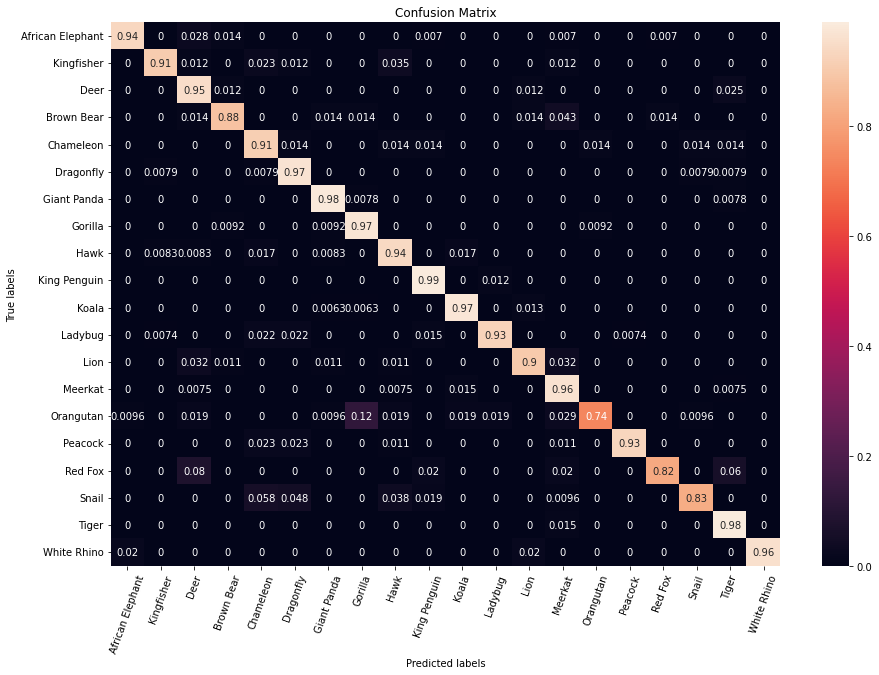

Predicted label ['Deer' 'Deer' 'Kingfisher' 'Snail' 'Chameleon' 'Deer']
True label ['African Elephant' 'Kingfisher' 'Dragonfly' 'Orangutan' 'Ladybug'
 'Red Fox']
Corresponding images are shown below
Top 1 accuracy: 0.817, Top 5 accuracy: 0.9635


(0.817, 0.9635)

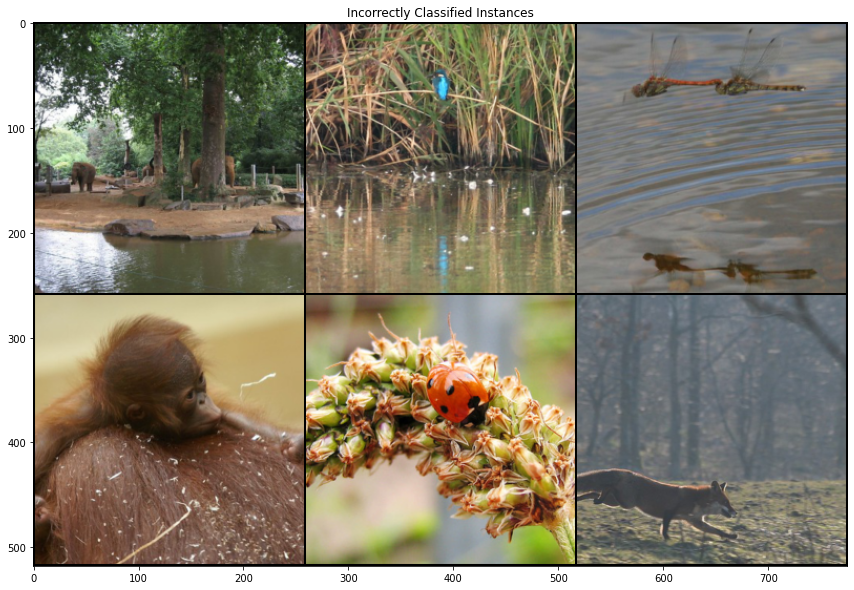

In [ ]:
# Run once your have trained your final model
model = MyResNet()
model.load_state_dict(torch.load('model_iter9.pt'))
model.to(device=device)
check_accuracy(loader_val, model, analysis=True)
check_accuracy_top5(loader_test, model)

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**

There are three well known systematic approaches to hyperparameter tuning - Grid Search, Random Search and Bayesian Optimization. These approaches fall into two catagories, parallel search and sequential optimization:

- Parallel search (Grid Search, Random Search):

Both Grid Search and Random Search perform many parallel network training runs, each with different hyperparameter configurations. The best outcome is then selected. The two differ in their approach as where Grid Search selects hyperparameter values in evenly spaced intervals, Random Search randomly samples within specified ranges. Both methods have associated high computational cost. 

- Sequential Optimization (Bayesian Optimization):

In Bayesian Optimization, networks are trained sequentually with different hyperparameter configurations, each iteration guiding the next one as the process converges onto the optimal configuration. In general, Bayesian Optimization will lead to the best hyperparameters. However, this requires multiple successive training iterations, and is therefore highly computationally expensive.

Random Search is the most efficient hyperparameter searching strategy, although less likely to converge on the optimal hyperparameters than Bayesian Optimization. In practice Grid Search is commonplace due to its relative simplicity.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions 

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**


I change the network, both in its architecture and hyperparameters, gradually in an iterative process, exploring small changes at each timestep. This is done for a total of ten iterations. 

Iteration 0:
The network is trained with exactly the baseline parameters provided:

{
Data augmentation - None,
Model architecture - base ResNet18 (unchanged),
Batch size - 128,
Optimizer - Adamax,
Scheduler - None,
Learning rate - 1e-4,
Weight decay - 1e-7,
Epochs - 10,
}

Number of model parameters = 11,204,164

We observe very poor performance, with the network obtaining a validation error rate of no lower than 60%. Our initial hypothesis for the poor performance is that the network is not being allowed to train for a sufficient number of epochs, and therefore is not allowed to learn meaningful image representations, leading to poor classification of the validation set. However, this is contradicted by the plateaued curve for iteration 0 in the validation error training curve, indicating that the model is not underfitting but instead learning poor image representations. In iteration 1, the number of epochs is increased to 30. 

Iteration 1:

{
Data augmentations - None,
Model architecture - base ResNet18 (unchanged),
Batch size - 128,
Optimizer - Adamax,
Scheduler - None,
Learning rate - 1e-4,
Weight decay - 1e-7,
Epochs - 30,
}

Number of model parameters = 11,204,164

We find that the validation error actually increases, up by 5% to 65%. The model is now heavily overfitting to the training set. To counteract this, in iteration 2 we investigate the effect of increasing the learning rate, increasing the weight decay, and using a learning rate scheduler. We implement a cosine annealing learning rate (Loshchilov & Hutter, 2016). Why?

Using a learning rate schedule tends to accelerate the learning of a deep neural network. Due to the inherent complexity of the geometry of loss surfaces when training large networks (millions of parameters), there exists minimal theoretical underpinning for this observation - that said, much empirical analysis has been performed to support this (e.g. Gotmare et al., 2018). 

With a cosine annealing learning rate scheduler, the learning rate decays from an initial value to a final value along a cosine curve. If one doesn’t consider restarts (which we don’t in this analysis), where after one decay length the learning rate restarts to the initial value, the only parameters that must be set are the initial learning rate, the final learning rate, and the decay length. We set the decay length to be the same as the total number of training epochs, and the final learning rate to be 0. The intuition behind using a decaying learning rate is that initially we want the learning rate to be high, such that we move rapidly in the direction of descent on the loss surface, and then a small learning rate is desired during the final stages of training, such that we prevent chaotic changes to the weights. This allows the network to 'refine' the solution, such that it can settle in narrow minima and prevent optimization divergences. 

The increase to the (initial) learning rate and weight decay from iterations 1 to 2 are made to only investigate the effect of these changes - there is minimal theoretical motivation behind this decision, we are simply looking to empirically investigate the effect of using different values. 


Iteration 2:

{
Data augmentations - None,
Model architecture - base ResNet18 (unchanged),
Batch size - 128,
Optimizer - Adamax,
Scheduler - CosineAnnealingLR,
Learning rate - 1e-3,
Weight decay - 1e-3,
Epochs - 30,
}

Number of model parameters = 11,204,164

We find a large increase in the performance of the network - a validation error of 35% after 30 epochs. However, we note that the validation error initially decreases rapidly but then plateaus, suggesting that the network is not learning sufficiently rich representations of the images to generalise to new data. To counteract this, in the next iteration we apply image augmentations to the train data, forcing the network to learn more general representations of the different animals. 

We apply the following image augmentations to the train set:
- Random horizontal flipping (p = 0.5)
- Colour jittering (scale hue, saturation and brightness with coefficients uniformly drawn from [0.6, 1.4], contrast not modified)
- Random cropping (scale=(0.6, 1)) and Resizing


Iteration 3:

{
Data augmentations - 
			RandomHorziontalFlip(p=0.5),
			ColorJitter(0.4, 0, 0.4, 0.4),
			RandomResizedCrop(size=256, scale=(0.6,1)),

Model architecture - base ResNet18 (unchanged),
Batch size - 128,
Optimizer - Adamax,
Scheduler - CosineAnnealingLR,
Learning rate - 1e-3,
Weight decay - 1e-3,
Epochs - 30,

}

Number of model parameters = 11,204,164

The network obtains a validation error of under 20%, a significant improvement. This demonstrates that the image augmentations have had their desired effect, forcing the network to learn stronger image representations which overfit less to the peculiarities of the train set and instead to the true latent patterns in the data. 

This is now a very strong performance. However, from now we consider architectural changes to the baseline ResNet-18 model provided. 

First, in the next iteration we change the model architecture to be the original ResNet-18 model, instead of the ResNet-18 provided to us. The ResNet-18 provided to us (class ResNet in the code) has an initial 3x3 convolution (stride = 1, padding = 1) with 16 channels in the input stem, followed by a Batch Norm and then a ReLU activation before the input is passed to the first layer. In contrast, original ResNet-18 (hereafter referred to as vanilla ResNet-18, the ResNet provided to us is referred to as ResNet_base) has a larger initial 7x7 convolution (stride = 2, padding = 3) with 64 channels, and then is followed (after the Batch Norm and ReLU activation) by a 3x3 max pooling layer (also with a stride of 2). ResNet_base then has 6 residual blocks, whereas the vanilla ResNet-18 has 4. ResNet_base, after the sixth residual block, performs a 4x4 max pooling, whereas vanilla ResNet-18 performs a global average pooling. Vanilla ResNet-18 is implemented in the class ResNet18 in the code.

The main motivation behind this architectural change is not to improve model performance, rather to compare to baselines in the literature (which implement vanilla ResNet-18), particularly when performing further architectural tweaks in following iterations. That said, it is still interesting to observe how this changes the network’s performance on the Natural ImageNet classification task, since non-insignificant architectural modifications have been made. These changes decrease the number of model parameters slightly, but only by 0.2%.

Iteration 4:

{
Data augmentations - 
			RandomHorziontalFlip(p=0.5),
			ColorJitter(0.4, 0, 0.4, 0.4),
			RandomResizedCrop(size=256, scale=(0.6,1)),

Model architecture - vanilla ResNet18,
Batch size - 128,
Optimizer - Adamax,
Scheduler - CosineAnnealingLR,
Learning rate - 1e-3,
Weight decay - 1e-3,
Epochs - 30,
}

Number of model parameters = 11,186,772

The network obtains a validation error of 22%, which is a slight increase from iteration 3.

We now consider small architectural tweaks in vanilla ResNet, motivated by [He et al., 2018]. We first implement what He et al. refer to as ResNet-C (class ResNet18C in the code), where the 7x7 convolution in the input stem is replaced with 3 3x3 convolutions, where the first two convolutions have 32 channels and stride 2 and the third convolution has 64 channels. This is principally motivated by the reduction in computational cost, since a 3x3 convolution is 5.4 times less expensive than a 7x7 convolution, although He et al. do find that this change does improve the model performance, increasing the top-1 accuracy on ImageNet by 0.66% (using ResNet-50). 


Iteration 5:

{
Data augmentations - 
			RandomHorziontalFlip(p=0.5),
			ColorJitter(0.4, 0, 0.4, 0.4),
			RandomResizedCrop(size=256, scale=(0.6,1)),

Model architecture - ResNet18-C, 
Batch size - 128,
Optimizer - Adamax,
Scheduler - CosineAnnealingLR,
Learning rate - 1e-3,
Weight decay - 1e-3,
Epochs - 30,
}

Number of parameters = 11,206,004

We find that the network achieves the best classification error rate so far on the validation set, 17%, although it does fluctuate rapidly around 20% for the final 10 or so epochs of the training (suggesting slight overfitting to the train set).

He et al. also propose the architectural tweak ResNet-D (class ResNet18D in the code), which we implement in iteration 6, although slightly modified (the original implementation is done with ResNet-50, whereas we are using ResNet-18). Instead of modifying the convolutions in the stem, as done in ResNet-C, ResNet-D instead modifies the residual blocks - vanilla ResNet-18 implements a 1x1 convolution in path B of the block (the ‘shortcut’ path). However, this ignores 3/4 of the input feature map (when the stride is 2, which it is in layers 2, 3 and 4). Therfore, to prevent information being ignored, a 2x2 averaging pooling layer is added before the convolution (whose stride is changed to always be 1). 

Iteration 6:

{
Data augmentations - 
			RandomHorziontalFlip(p=0.5),
			ColorJitter(0.4, 0, 0.4, 0.4),
			RandomResizedCrop(size=256, scale=(0.6,1)),

Model architecture - ResNet18-D,
Batch size - 128,
Optimizer - Adamax,
Scheduler - CosineAnnealingLR,
Learning rate - 1e-3,
Weight decay - 1e-3,
Epochs - 30,
}

Number of parameters = 11,186,772

This changes the performance from vanilla ResNet-18 very little - validation error of 20% after 30 epochs. 

In iteration 7 we combine these architectural tweaks, coining the resulting architecture ResNet18-E (class ResNet18E in the code).

Iteration 7:

{
Data augmentations - 
			RandomHorziontalFlip(p=0.5),
			ColorJitter(0.4, 0, 0.4, 0.4),
			RandomResizedCrop(size=256, scale=(0.6,1)),

Model architecture - ResNet18-E,
Batch size - 128,
Optimizer - Adamax,
Scheduler - CosineAnnealingLR,
Learning rate - 1e-3,
Weight decay - 1e-3,
Epochs - 30,
}

Number of parameters = 11,206,004

We see a marked improvement in network performance - validation error of 18%. However, we note that this is achieved after 28 of the 30 epochs, after which the validation error increases slightly to 20% after 30 epochs. This could arise due to the inherent instability in the learning process, although it is possible that the network overfits to the training data. This is considered further in iteration 9. 
The next iteration sees the implementation of Squeeze-and-Excitation networks [Hu et al., 2019], producing the new architecture SE-ResNet-18-E (class ResNet18E_SE in the code). 

What’s a Squeeze-and-Excitation network?

A squeeze-and-excitation network is one which contains squeeze-and-excitation blocks. These blocks implement global averaging pooling (squeeze) followed by a two-layer MLP with a sigmoid nonlinearity (excitation). The weights in the MLP are learnt as the network trains. This then allows cross-channel interactions, resulting in channel reweighting and ultimately performance gains, since feature-dependencies between channels are now modelled.

In iteration 8 we additionally reduce the learning rate to 1e-4, in response to the slight overfitting to the train set in iteration 7.

Iteration 8:

{
Data augmentations - 
			RandomHorziontalFlip(p=0.5),
			ColorJitter(0.4, 0, 0.4, 0.4),
			RandomResizedCrop(size=256, scale=(0.6,1)),

Model architecture - SE-ResNet18-E,
Batch size - 128,
Optimizer - Adamax,
Scheduler - CosineAnnealingLR,
Learning rate - 1e-4,
Weight decay - 1e-3,
Epochs - 30,
}

Number of parameters = 11,293,044

Validation error of 25% after 30 epochs. This is a rise of 8% from the previous iteration. However, we note that the validation error is consistently decreasing (it doesn’t plateau), suggesting that training has been halted too early - in hindsight this could have been foreseen with the reduction of the learning rate by ten fold. Therefore, in iteration 9, we allow the network to train for 50 epochs. To further mitigate against overfitting we add another image augmentation: Gaussian noise (mean 0, std 0.1) is applied to each image in the train set with probability 0.5. 

Iteration 9:

{
Data augmentations - 
			RandomHorizontalFlip(p=0.5),
			ColorJitter(0.4, 0, 0.4, 0.4),
			RandomResizedCrop(size=256, scale=(0.6,1)),
RandomGaussianNoise((mean=0, std=0.1), p=0.5),

Model architecture - SE-ResNet18-E,
Batch size - 128,
Optimizer - Adamax,
Scheduler - CosineAnnealingLR,
Learning rate - 1e-4,
Weight decay - 1e-3,
Epochs - 50,
}

Number of parameters = 11,293,044

This iteration leads to the best network performance - a validation error of 17% after 50 epochs. The validation error begins to plateau towards epoch 50, expected as the learning rate drops to 0. This trained model is saved in the directory 'saved_models'. 

The trained model from iteration 9 is then evaluated on the test set, producing a top-1 accuracy of 81.70% and a top-5 accuracy of 96.35%.

---

<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(: 

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

- In the lower-level layers the network appears to identify key features in the image - e.g. edges, corners, texture patterns. These appear to correspond to the type of salient features classical computer vision algorithms extract, e.g. SIFT. 

- As the image moves through the network into the higher-level layers, the image representations across the filter channels become much more abstract and uninterpretable (to humans), although it does appear that the network focusses on broader shapes instead of finer details (such as edges). Instead of being handcrafted like in classical computer vision algorithms, the network has automatically learnt the salient features to extract from the images for accurate classification. We note that the image activations seem to be different between the filter channels for the higher-level layers, suggesting that the network is efficient in its learning process, using each channel to learn a different image feature (there appears to be minimal cross-channel redundancy).

- As the image moves through the layers of the network, the image becomes 'blurrier' as it is gradually downsampled (necessary for eventual classification between 20 classes).

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

The performance of the network after iteration 9 is strong - a top-1 (5) accuracy of 81.7% (96.35%) on the test set. As a measure of comparison, the current state-of-the-art performance for ImageNet classification with a ResNet architecture is a top-1 accuracy of 87.54% on the ILSVRC-2012 test set (Kolesnikov et al., 2020). However, the Big Transfer (BiT) model produced by Kolesnikov et al. was pre trained on millions of labelled images (before being fine tuned on ImageNet), whereas we are limited to a significantly smaller training set with randomly initialised network weights. 

However, undoubtedly it is possible to achieve a stronger performance than we do after iteration 9 - extensive hyperparameter tuning has not been performed due to the associated computational costs, and so a more optimal hyperparameter configuration is certainly achievable. Further, there are alternative hyperparameter choices which aren’t considered in this analysis. An example of this is using alternative optimizers, such as SGD or LARS, or using alternative learning rate schedulers, such as Cosine Annealing Warm Restarts. We additionally fix the batch size at 128 throughout this analysis - it is possible that tuning this value as well could further improve network performance. That said, it remains likely that the ResNet-18 architecture does not have the model capacity to learn sufficiently rich image representations from the Natural ImageNet dataset to achieve a test top-1 accuracy of far above 80%. Improving the performance further above 80%, therefore, may require a larger network, such as ResNet-50. However, due to the relatively small size of the training set (approx. 18k images), we anticipate that such a large network (approx. 26 million parameters) will always underfit to the training data. Possible other alternative improvements are to use a larger number of image augmentations, such as RandAugment (Cubuk et. al, 2019), which applies a sequence of random augmentations, or AutoAugment (Cubuk et al., 2018), which applies a sequence of learnt image augmentations from data. Ultimately, however, using a larger training dataset is the most direct way to achieve stronger network performance. 

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

So far, only the accuracy of the network has been used to analyse performance. However, more specific information about how well the network classifies the different animal classes can be extracted from the confusion matrix, specifically in the form of the precision and recall, as well as the class specific accuracy. For example, we find that the model (from iteration 9) struggles to correctly classify the Orangutan, achieving an accuracy of only 74%, and particularly confuses it with the Gorilla (12% of the time). This is possibly due to the colour jitter image augmentation applied to the train data, since one of the most differences between the Gorilla and the Orangutan is the animal colour. An alternative scoring metric, therefore, that takes into account this confusion is F1 score. 

AUROC (area under receiver operator curve) can also be used as an alternative metric to accuracy, which provides a measure of model performane across all classification thresholds. 

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture). 

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [ ]:
import matplotlib.pyplot as plt
import random


def plot_model_features(randint):
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']  #, 'layer5', 'layer6']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))
        

    data, _ = test_dataset[randint]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2
        
        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



<Figure size 432x288 with 0 Axes>

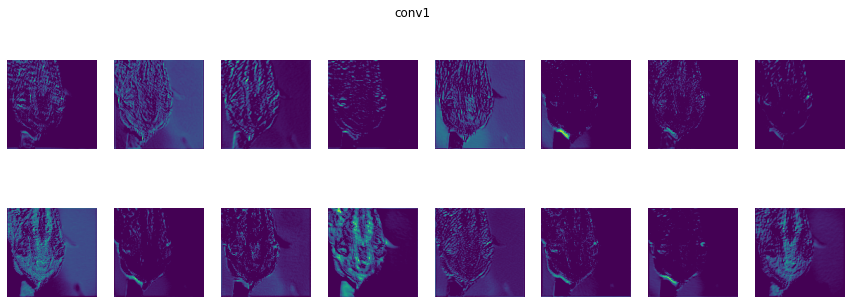

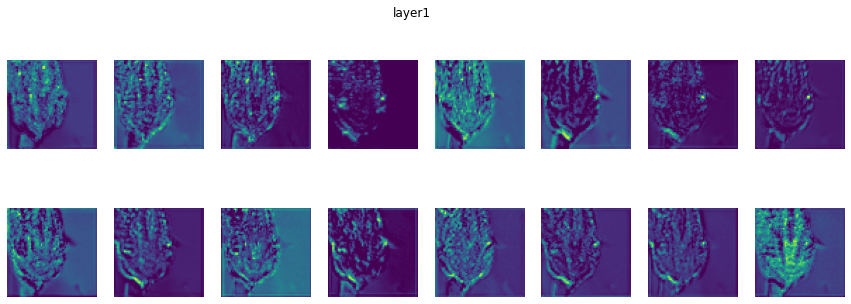

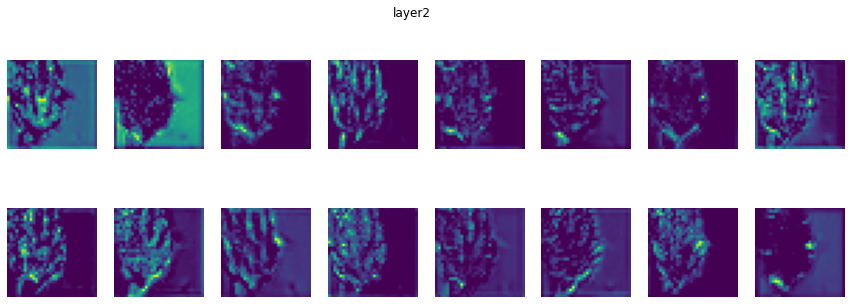

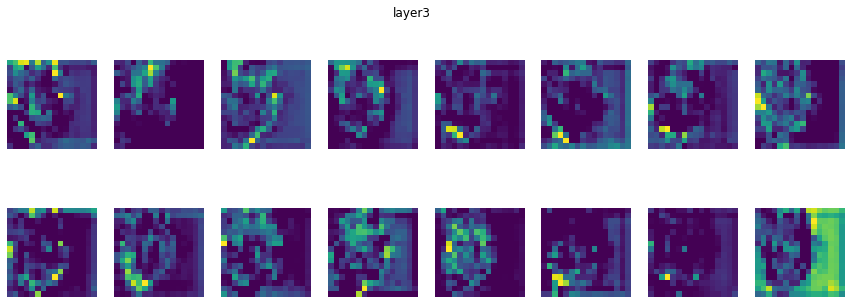

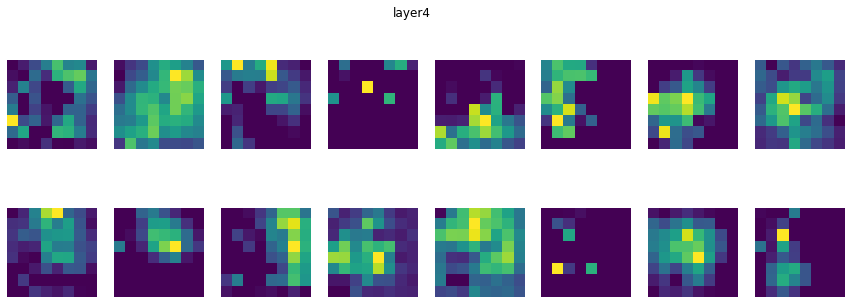

<Figure size 432x288 with 0 Axes>

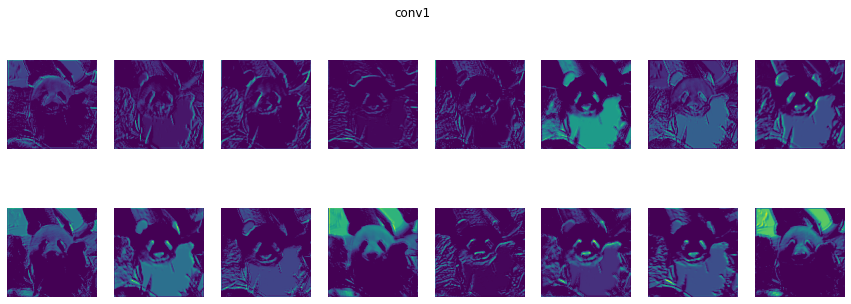

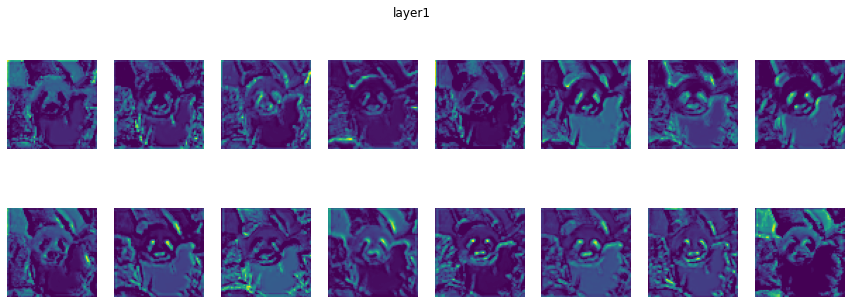

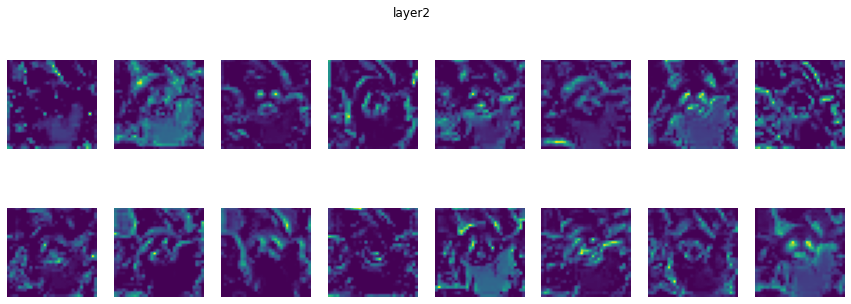

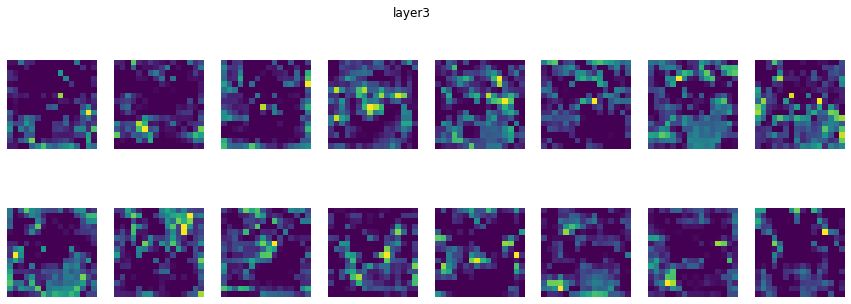

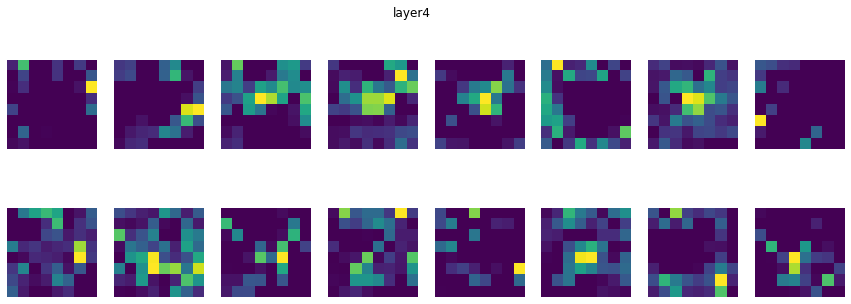

In [ ]:
# Visualize the figure here, so it is exported nicely
plot_model_features(random.randint(0, 999))  

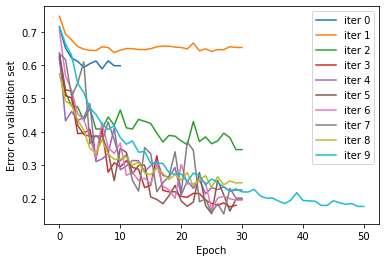

In [1]:
## Useful plots (from iteration logs)

import matplotlib.pyplot as plt
import numpy as np

n_iters = 10

for i in range(n_iters):

    fname = f"logs/iter{i}.txt"

    val = []
    with open(fname, "r") as f:
        for line in f:
            line = line.strip()
            if "val set" in line:
                open_b = line.index("(")
                close_b = line.index(")")
                val_err = 1. - float(line[open_b+1:close_b])/100
                val.append(val_err)

    plt.plot(np.arange(len(val)), val, label=f"iter {i}")

plt.xlabel("Epoch")
plt.ylabel("Error on validation set")
plt.legend()
plt.show()

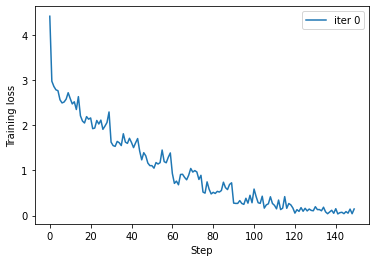

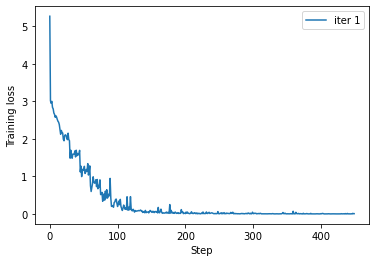

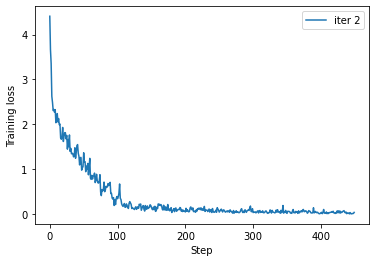

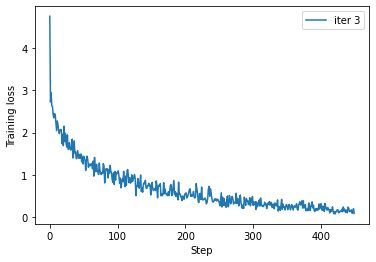

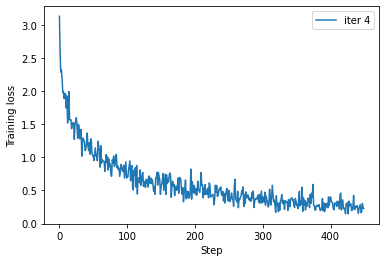

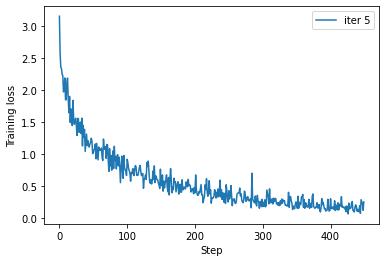

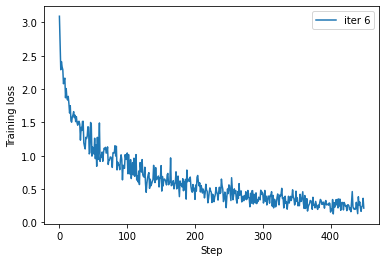

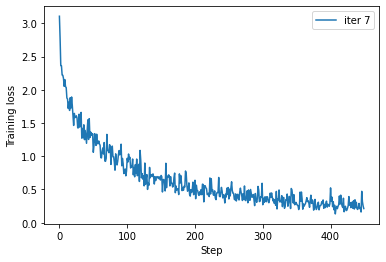

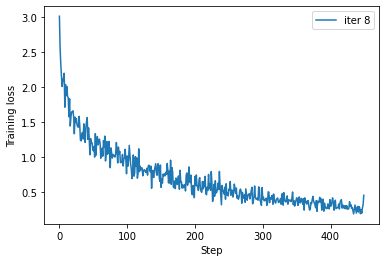

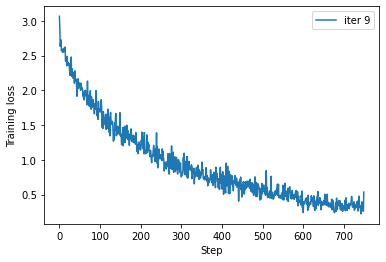

In [2]:
import matplotlib.pyplot as plt
import numpy as np

n_iters = 10

for i in range(n_iters):

    fname = f"logs/iter{i}.txt"

    train = []
    with open(fname, "r") as f:
        for line in f:
            line = line.strip()
            if "Epoch" in line:
                line = line.split()
                loss = float(line[-1])
                train.append(loss)

    plt.plot(np.arange(len(train)), train, label=f"iter {i}")
    plt.xlabel("Step")
    plt.ylabel("Training loss")
    plt.legend()
    plt.savefig(f"plots/plot_train_{i}.pdf")
    plt.savefig(f"plots/plot_train_{i}.png")
    plt.show()

<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

BatchNorm Layer results: All test cases passed!

Convolution Layer results: All test cases passed!

Linear Layer results: All test cases passed!

MaxPool Layer results: All test cases passed!

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)